In [23]:
import pandas as pd
from tensorflow.python.summary.summary_iterator import summary_iterator
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [16]:
#gather event files
data_dir = "/home/han/localdata/data/waspaa_data/waspaa_models/"
event_fs = []
domains = []
archs = []
inits = []
for root, dir, paths in os.walk(data_dir):
    for path in paths:
        if "events." in path:
            #extract setting for each file
            domains.append(root.split("/")[8])
            archs.append(root.split(",")[2][5:])
            inits.append(int(root.split(",")[3].split("/")[0][8:]))
            event_fs.append(os.path.join(root,path))

In [17]:
runlogs = []
len_epochs = []
for i, data_dir in enumerate(event_fs):
    runlog = {"val_loss":[], "train_loss":[], "arch": archs[i], "inits": inits[i], "domain": domains[i], "epoch":[]}
    for e in summary_iterator(data_dir): #iterate over event
        for v in e.summary.value: 
            if v.tag in runlog.keys():
                if v.tag == "epoch" and v.simple_value not in runlog[v.tag]:
                    runlog[v.tag].append(v.simple_value)
                elif v.tag != "epoch":
                    runlog[v.tag].append(v.simple_value)
    #filter out the uneffective events
    if len(runlog["epoch"]) > 1:
        runlogs.append(runlog)
        len_epochs.append(len(runlog["epoch"]))
                    
min_len_epochs = min(len_epochs)

#reorganize log
all_logs = {"train_loss":[], "val_loss":[], "epoch":[], "domain":[], "arch":[], "inits":[]}
for runlog in runlogs:
    all_logs["train_loss"].extend(runlog["train_loss"][:min_len_epochs])
    all_logs["val_loss"].extend(runlog["val_loss"][:min_len_epochs])
    all_logs["epoch"].extend(runlog["epoch"][:min_len_epochs])
    all_logs["domain"].extend([runlog["domain"]] * min_len_epochs)
    all_logs["arch"].extend([runlog["arch"]] * min_len_epochs)
    all_logs["inits"].extend([runlog["inits"]] * min_len_epochs)
all_logs = pd.DataFrame(all_logs)


In [18]:
all_logs

,train_loss,val_loss,epoch,domain,arch,inits
0,-0.522040,-0.591690,0.0,speech,TDFilterbank,0
1,-0.627831,-0.667853,1.0,speech,TDFilterbank,0
2,-0.686763,-0.721565,2.0,speech,TDFilterbank,0
3,-0.732060,-0.759859,3.0,speech,TDFilterbank,0
4,-0.769918,-0.791215,4.0,speech,TDFilterbank,0
...,...,...,...,...,...,...
5275,-0.729904,-0.733285,83.0,urban,Gabor1D,1
5276,-0.730372,-0.733217,84.0,urban,Gabor1D,1
5277,-0.730295,-0.733393,85.0,urban,Gabor1D,1
5278,-0.731020,-0.733036,86.0,urban,Gabor1D,1


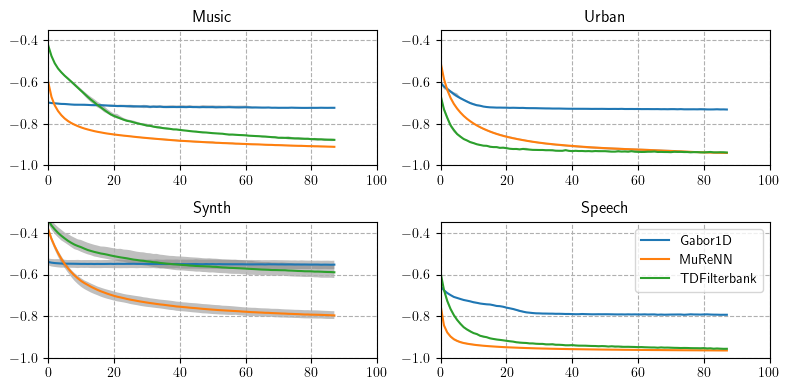

In [42]:
#fig, axes = plt.subplots(2,2,figsize=(8,4))
fig2, axes2 = plt.subplots(2,2,figsize=(8,4))
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif"
})
ind_x = [0,0,1,1]
ind_y = [0,1,0,1]
os.makedirs("./curves", exist_ok=True)
for i, domain in enumerate(["music", "urban", "synth", "speech"]):
    for model in ["Gabor1D", "MuReNN", "TDFilterbank"]:
        train_losses = []
        val_losses = []
        for init in range(5):
            train_losses.append(np.array(all_logs[all_logs["domain"]==domain][all_logs["arch"]==model][all_logs["inits"]==init]["train_loss"]))
            val_losses.append(np.array(all_logs[all_logs["domain"]==domain][all_logs["arch"]==model][all_logs["inits"]==init]["val_loss"]))
        #print(train_losses, domain, model)
        train_losses = np.stack(train_losses).T
        val_losses = np.stack(val_losses).T
        #save to numpy
        np.save( "curves/" + domain + model+".npy",[train_losses, val_losses], allow_pickle=True)
        #plot train loss
        #axes[ind_x[i],ind_y[i]].plot(np.mean(train_losses, axis=1), label=model)
        #axes[ind_x[i],ind_y[i]].fill_between(np.arange(0,train_losses.shape[0]), np.min(train_losses,axis=1), np.max(train_losses,axis=1), facecolor='grey', alpha=0.5)
        #axes[ind_x[i],ind_y[i]].set_title(domain.capitalize())
        #axes[ind_x[i],ind_y[i]].set_ylim([-1, -0.35])
        #axes[ind_x[i],ind_y[i]].set_xlim([0, 100])
        #axes[ind_x[i],ind_y[i]].grid(linestyle='--')
        #plot val loss
        axes2[ind_x[i],ind_y[i]].plot(np.mean(val_losses, axis=1), label=model)
        axes2[ind_x[i],ind_y[i]].fill_between(np.arange(0,val_losses.shape[0]), np.min(val_losses,axis=1), np.max(val_losses,axis=1), facecolor='grey', alpha=0.5)
        axes2[ind_x[i],ind_y[i]].set_title(domain.capitalize())
        axes2[ind_x[i],ind_y[i]].set_ylim([-1, -0.35])
        axes2[ind_x[i],ind_y[i]].set_xlim([0, 100])
        axes2[ind_x[i],ind_y[i]].grid(linestyle='--')
plt.tight_layout()
plt.legend()




